In [16]:
import psycopg2
import pandas as pd 
# from sqlalchemy.types import Integer, Text, String, DateTime
import sqlalchemy as s
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = s.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [17]:
repo_list = pd.DataFrame()
repo_list_query = f"""
SELECT repo_id, repo_name, repo_path from repo
WHERE repo_name = 'concourse' OR repo_name = 'postfacto' or repo_name = 'clarity' or repo_name = 'gpdb' or
      repo_name = 'kpack' or repo_name = 'rabbitmq-server' or repo_name = 'sonobuoy' 
      or repo_name = 'spring-framework' or repo_name = 'gporca-pipeline-misc' or repo_name = 'initializr';
    """
repo_list = pd.read_sql_query(repo_list_query, con=engine)
print(repo_list)

    repo_id             repo_name                              repo_path
0     27913               clarity                     github.com/vmware/
1     25857                  gpdb               github.com/greenplum-db/
2     26983             postfacto                    github.com/pivotal/
3     26235             concourse               github.com/pcfdev-forks/
4     25432       rabbitmq-server                   github.com/rabbitmq/
5     25622            initializr                  github.com/spring-io/
6     28030              sonobuoy               github.com/vmware-tanzu/
7     26600                  gpdb  github.com/Pivotal-Field-Engineering/
8     26001            initializr                github.com/SteeltoeOSS/
9     27169                  gpdb                github.com/pivotal-gss/
10    28051             concourse                  github.com/concourse/
11    25663      spring-framework            github.com/Spring-projects/
12    25881  gporca-pipeline-misc               git

In [18]:
## List of repository IDs for the report
#repo_dict = {25760, 25663} #spring-boot & spring-framework
#repo_dict = {28051} # concourse
#repo_dict = {26983} #postfacto
#repo_dict = {25432} #rabbitmq-server
#repo_dict = {25663} #spring-framework
#repo_dict = {28030} #sonobuoy
#repo_dict = {28031} #velero
repo_dict = {26001}

In [19]:
#from datetime import date
import datetime 

current = datetime.date.today()
today = "'" + str(current) + "'"
print(today)

first_current = current.replace(day=1)
last_month = first_current - datetime.timedelta(days=1)
end_date = "'" + str(last_month) + "'"
print(end_date)

print

start = last_month - datetime.timedelta(days=365)
year_ago = "'" + str(start) + "'"
print(year_ago)

'2020-04-30'
'2020-03-31'
'2019-04-01'


In [20]:
# Monthly PRs closed
pr_monthDF = pd.DataFrame()
for value in repo_dict: 
    pr_monthquery = f"""
                    SELECT
                        * 
                    FROM
                        (
                        SELECT
                            date_part( 'year', month :: DATE ) AS YEAR,
                            date_part( 'month', month :: DATE ) AS month 
                        FROM
                            ( SELECT * FROM ( SELECT month :: DATE FROM generate_series ( TIMESTAMP {year_ago}, TIMESTAMP {end_date}, INTERVAL '1 month' ) month ) d ) x 
                        ) y
                        LEFT OUTER JOIN (
                        SELECT
                            repo_id,
                            repo_name,
                            repo_group,
                            date_part( 'year', pr_created_at :: DATE ) AS YEAR,
                            date_part( 'month', pr_created_at :: DATE ) AS month,
                            COUNT ( pr_src_id ) AS total_prs_open_closed 
                        FROM
                            (
                            SELECT
                                repo.repo_id AS repo_id,
                                repo.repo_name AS repo_name,
                                repo_groups.rg_name AS repo_group,
                                pull_requests.pr_created_at AS pr_created_at,
                                pull_requests.pr_closed_at AS pr_closed_at,
                                pull_requests.pr_src_id AS pr_src_id
                            FROM
                                repo,
                                repo_groups,
                                pull_requests 
                            WHERE
                                repo.repo_group_id = repo_groups.repo_group_id 
                                AND repo.repo_id = pull_requests.repo_id 
                                AND repo.repo_id = {value} 
                                AND pull_requests.pr_src_state = 'closed'  
                            ) L 
                        GROUP BY
                            L.repo_id,
                            L.repo_name,
                            L.repo_group,
                            YEAR,
                            month 
                        ORDER BY
                            repo_id,
                            YEAR,
                            month 
                        ) T USING ( month, YEAR ) 
                    ORDER BY
                        YEAR,
                        month;

        """
    pr_monthDFa = pd.read_sql_query(pr_monthquery, con=engine)
    repo_id = value

    pr_monthDFa[['repo_id']] = pr_monthDFa[['repo_id']].fillna(value=repo_id)
    
    # Hack to fill in repo_name where there are nan's
    get_repo_name_query = f"""
        SELECT repo_name from repo where repo_id = {value};
           """
    get_repo_name = pd.read_sql_query(get_repo_name_query, con=engine)
    repo_name = get_repo_name.repo_name[0]
    pr_monthDFa[['repo_name']] = pr_monthDFa[['repo_name']].fillna(value=repo_name)
    
    if not pr_monthDF.empty: 
        pr_monthDF = pd.concat([pr_monthDF, pr_monthDFa]) 
    else: 
        pr_monthDF = pr_monthDFa
        pr_monthDF.set_index('repo_id', 'year', 'month')


pr_monthDF.set_index('repo_id', 'year', 'month')

pr_monthDF[['total_prs_open_closed']] = pr_monthDF[['total_prs_open_closed']].fillna(0)

pr_monthDF['year'] = pr_monthDF['year'].map(int)
pr_monthDF['month'] = pr_monthDF['month'].map(int)
pr_monthDF['month'] = pr_monthDF['month'].apply('{:0>2}'.format)
pr_monthDF['yearmonth'] = pr_monthDF['year'].map(str)+ pr_monthDF['month'].map(str)


In [22]:
pr_monthDF

,month,year,repo_id,repo_name,repo_group,total_prs_open_closed,yearmonth
0,04,2019,26001.0,initializr,None,0.0,201904
1,05,2019,26001.0,initializr,None,0.0,201905
2,06,2019,26001.0,initializr,None,0.0,201906
3,07,2019,26001.0,initializr,SteeltoeOSS,2.0,201907
4,08,2019,26001.0,initializr,SteeltoeOSS,15.0,201908
5,09,2019,26001.0,initializr,SteeltoeOSS,5.0,201909
6,10,2019,26001.0,initializr,SteeltoeOSS,7.0,201910
7,11,2019,26001.0,initializr,SteeltoeOSS,2.0,201911
8,12,2019,26001.0,initializr,SteeltoeOSS,4.0,201912
9,01,2020,26001.0,initializr,SteeltoeOSS,1.0,202001


In [21]:
pr_sustainDF = pd.DataFrame()
pr_sustainDF['yearmonth'] = pr_monthDF['yearmonth']
pr_sustainDF['repo_name'] = pr_monthDF['repo_name']
pr_sustainDF['repo_id'] = pr_monthDF['repo_id']
pr_sustainDF['closed_total'] = pr_monthDF['total_prs_open_closed']
print(pr_sustainDF)

   yearmonth   repo_name  repo_id  closed_total
0     201904  initializr  26001.0           0.0
1     201905  initializr  26001.0           0.0
2     201906  initializr  26001.0           0.0
3     201907  initializr  26001.0           2.0
4     201908  initializr  26001.0          15.0
5     201909  initializr  26001.0           5.0
6     201910  initializr  26001.0           7.0
7     201911  initializr  26001.0           2.0
8     201912  initializr  26001.0           4.0
9     202001  initializr  26001.0           1.0
10    202002  initializr  26001.0           0.0
11    202003  initializr  26001.0           4.0


In [12]:
# Monthly PRs ALL - removed where pull_requests.pr_src_state = 'closed' 
pr_monthDF = pd.DataFrame()

for value in repo_dict: 
    pr_monthquery = f"""
                    SELECT
                        * 
                    FROM
                        (
                        SELECT
                            date_part( 'year', month :: DATE ) AS YEAR,
                            date_part( 'month', month :: DATE ) AS month 
                        FROM
                            ( SELECT * FROM ( SELECT month :: DATE FROM generate_series ( TIMESTAMP {year_ago}, TIMESTAMP {end_date}, INTERVAL '1 month' ) month ) d ) x 
                        ) y
                        LEFT OUTER JOIN (
                        SELECT
                            repo_id,
                            repo_name,
                            repo_group,
                            date_part( 'year', pr_created_at :: DATE ) AS YEAR,
                            date_part( 'month', pr_created_at :: DATE ) AS month,
                            COUNT ( pr_src_id ) AS total_prs_open_closed 
                        FROM
                            (
                            SELECT
                                repo.repo_id AS repo_id,
                                repo.repo_name AS repo_name,
                                repo_groups.rg_name AS repo_group,
                                pull_requests.pr_created_at AS pr_created_at,
                                pull_requests.pr_closed_at AS pr_closed_at,
                                pull_requests.pr_src_id AS pr_src_id
                            FROM
                                repo,
                                repo_groups,
                                pull_requests 
                            WHERE
                                repo.repo_group_id = repo_groups.repo_group_id 
                                AND repo.repo_id = pull_requests.repo_id 
                                AND repo.repo_id = {value} 
                            ) L 
                        GROUP BY
                            L.repo_id,
                            L.repo_name,
                            L.repo_group,
                            YEAR,
                            month 
                        ORDER BY
                            repo_id,
                            YEAR,
                            month 
                        ) T USING ( month, YEAR ) 
                    ORDER BY
                        YEAR,
                        month;

        """
    pr_monthDFa = pd.read_sql_query(pr_monthquery, con=engine)
    repo_id = value
#    pr_monthDFa[['wk_avg_hours_to_close', 'wk_avg_days_to_close', 'total_prs_open_closed' ]] = pr_monthDFa[['wk_avg_hours_to_close', 'wk_avg_days_to_close', 'total_prs_open_closed' ]].fillna(value=0)
    pr_monthDFa[['repo_id']] = pr_monthDFa[['repo_id']].fillna(value=repo_id)
    
    # Hack to fill in repo_name where there are nan's
    get_repo_name_query = f"""
        SELECT repo_name from repo where repo_id = {value};
           """
    get_repo_name = pd.read_sql_query(get_repo_name_query, con=engine)
    repo_name = get_repo_name.repo_name[0]
    pr_monthDFa[['repo_name']] = pr_monthDFa[['repo_name']].fillna(value=repo_name)
    
    if not pr_monthDF.empty: 
        pr_monthDF = pd.concat([pr_monthDF, pr_monthDFa]) 
    else: 
        pr_monthDF = pr_monthDFa
        pr_monthDF.set_index('repo_id', 'year', 'month')


pr_monthDF.set_index('repo_id', 'year', 'month')

pr_monthDF[['total_prs_open_closed']] = pr_monthDF[['total_prs_open_closed']].fillna(0)


,,month,year,repo_name,repo_group,total_prs_open_closed
,repo_id,,,,,
0,26001.0,4.0,2019.0,initializr,None,NaN
1,26001.0,5.0,2019.0,initializr,None,NaN
2,26001.0,6.0,2019.0,initializr,None,NaN
3,26001.0,7.0,2019.0,initializr,SteeltoeOSS,2.0
4,26001.0,8.0,2019.0,initializr,SteeltoeOSS,15.0
5,26001.0,9.0,2019.0,initializr,SteeltoeOSS,5.0
6,26001.0,10.0,2019.0,initializr,SteeltoeOSS,7.0
7,26001.0,11.0,2019.0,initializr,SteeltoeOSS,2.0
8,26001.0,12.0,2019.0,initializr,SteeltoeOSS,4.0


In [13]:
pr_monthDF['total_prs_open_closed'].sum()

40.0

In [14]:
pr_sustainDF['all_total'] = pr_monthDF['total_prs_open_closed']
pr_sustainDF['diff'] = pr_sustainDF['all_total'] - pr_sustainDF['closed_total']
pr_sustainDF['diff_per'] = pr_sustainDF['diff'] / pr_sustainDF['all_total']
print(pr_sustainDF,'\n')
#print((pr_sustainDF['diff']).describe())

   yearmonth   repo_name  repo_id  closed_total  all_total  diff  diff_per
0     201904  initializr    26001           0.0        NaN   NaN       NaN
1     201905  initializr    26001           0.0        NaN   NaN       NaN
2     201906  initializr    26001           0.0        NaN   NaN       NaN
3     201907  initializr    26001           2.0        2.0   0.0       0.0
4     201908  initializr    26001          15.0       15.0   0.0       0.0
5     201909  initializr    26001           5.0        5.0   0.0       0.0
6     201910  initializr    26001           7.0        7.0   0.0       0.0
7     201911  initializr    26001           2.0        2.0   0.0       0.0
8     201912  initializr    26001           4.0        4.0   0.0       0.0
9     202001  initializr    26001           1.0        1.0   0.0       0.0
10    202002  initializr    26001           0.0        NaN   NaN       NaN
11    202003  initializr    26001           4.0        4.0   0.0       0.0 



In [10]:
today = datetime.date.today()
current_year_month = str(today.year) + '-' + '{:02d}'.format(today.month)
print(current_year_month)

2020-04


0


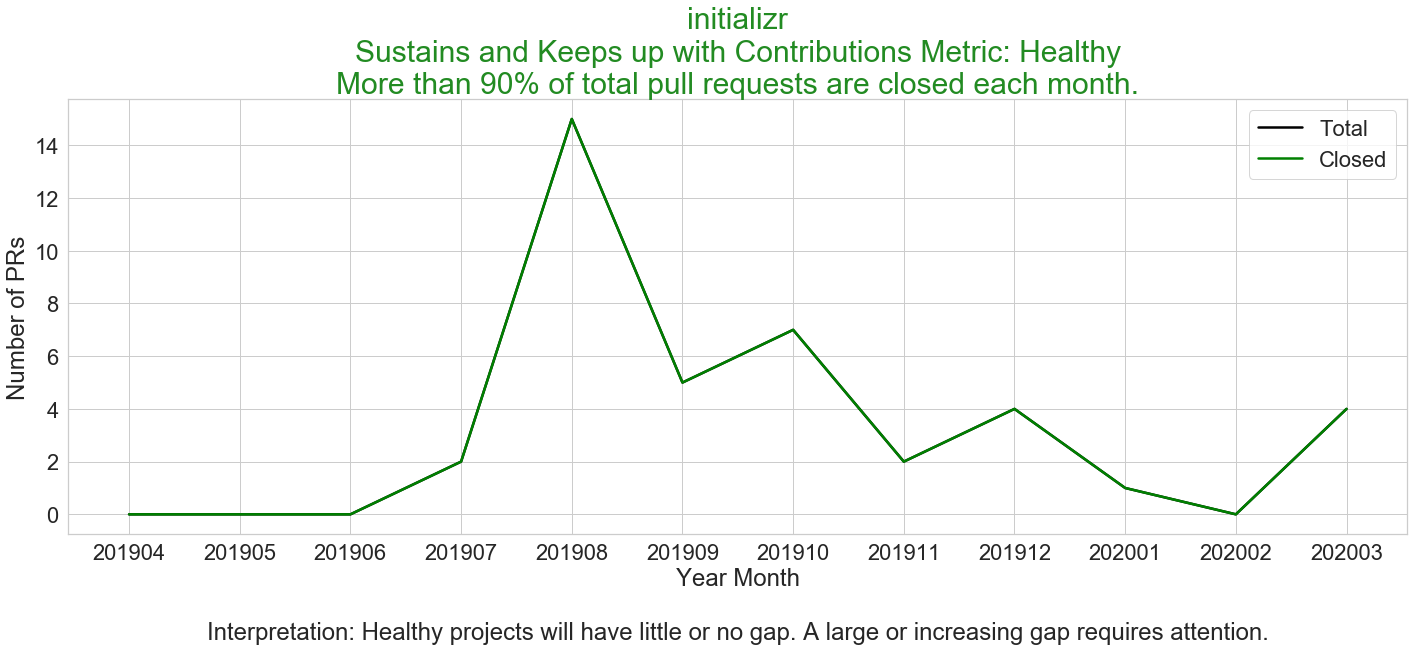

In [11]:
pr_sustainDF['repo_id'] = pr_sustainDF['repo_id'].map(int)
#pr_sustainDF['yearmonth'] = pr_sustainDF['yearmonth'].map(str)
pr_sustainDF.set_index('repo_id', 'yearmonth')

sns.set_style('ticks')
sns.set(style="whitegrid", font_scale=2)

fig, ax = plt.subplots()

# the size of A4 paper
fig.set_size_inches(24, 8)

risk_num = 0
h = 1
for diff_per in pr_sustainDF['diff_per']:
    if (diff_per > 0.10 and h >=6):
        risk_num+=1
    h+=1
print(risk_num)

title = pr_sustainDF['repo_name'][0] + "\nSustains and Keeps up with Contributions Metric:"

if risk_num >= 1:
    title += " AT RISK\n" + str(risk_num) + " month(s) with > 10% of total pull requests not closed"
    title_color = 'firebrick'
else:
    title += " Healthy\nMore than 90% of total pull requests are closed each month."
    title_color = 'forestgreen'

plottermonth = sns.lineplot(x='yearmonth', y='all_total', data=pr_sustainDF, sort=False, color='black', label='Total', linewidth=2.5)
plottermonth = sns.lineplot(x='yearmonth', y='closed_total', data=pr_sustainDF, sort=False, color='green', label='Closed', linewidth=2.5, linestyle='dashed').set_title(title, fontsize=30, color=title_color) 

plottermonthlabels = ax.set_xticklabels(pr_sustainDF['yearmonth'])
plottermonthlabels = ax.set_ylabel('Number of PRs')
plottermonthlabels = ax.set_xlabel('Year Month\n\nInterpretation: Healthy projects will have little or no gap. A large or increasing gap requires attention.')

today = datetime.date.today()
current_year_month = str(today.year) + '-' + '{:02d}'.format(today.month)

filename = 'output/sustains_pr_' + repo_name + "_" + current_year_month + '.png'

fig.savefig(filename, bbox_inches='tight')

In [41]:
print(sum(pr_monthDF.total_prs_open_closed))

602
